## CMPINF 2100 Week 13 | Managing Cross-Validation of Logistic Regression with SKLEARN

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

Let's return back to the complicated Week 12 Binary classification data set.

In [2]:
df = pd.read_csv('../week_12/week_12_binary_classification.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      300 non-null    float64
 1   x2      300 non-null    float64
 2   x3      300 non-null    float64
 3   x4      300 non-null    float64
 4   x5      300 non-null    object 
 5   y       300 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 14.2+ KB


### Goal

Use K-fold Cross-Validation to identify the BEST model out of 17 LOGISTIC REGRESSION MODELS fit in Week 12.

This time, use sklearn to not only generate the FOLDS but to also FIT the models and SCORE the models.

We will SPECIFY the assumptions of SKLEARN so that the logistic regression is consistent with statsmodels.

In [4]:
formula_list = ['y ~ 1', 
                'y ~ x5',
                'y ~ x1 + x2 + x3 + x4',
                'y ~ x1 + x2 + x3 + x4 + x5',
                'y ~ x5 * (x1 + x2 + x3 + x4)',
                'y ~ (x1 + x2 + x3 + x4) ** 2',
                'y ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)',
                'y ~ x5 + x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)',
                'y ~ x5 * (x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 + ((x1 + x2 + x3 + x4)**2 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 * ((x1 + x2 + x3 + x4)**2 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 + (x1 + x2 + x3 + x4)**3',
                'y ~x5 + (x1 + x2 + x3 + x4)**4',
                'y ~ (x1 + x2 + x3 + x4 + x5)**3',
                'y ~ (x1 + x2 + x3 + x4 + x5)**4',
                'y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2) + np.power(x1, 3) + np.power(x2, 3) + np.power(x3, 3) + np.power(x4, 3) )',
                'y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2) + np.power(x1, 3) + np.power(x2, 3) + np.power(x3, 3) + np.power(x4, 3) + np.power(x1, 4) + np.power(x2, 4) + np.power(x3, 4) + np.power(x4, 4) )'
               ]

In [5]:
formula_list[3]

'y ~ x1 + x2 + x3 + x4 + x5'

This is a classification problem so we MUST use STRATIFFIED cross-vlaidation.

In [6]:
from sklearn.model_selection import StratifiedKFold

We will use 5-fold cross-validation.

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9483156)

In [8]:
kf.get_n_splits()

5

We will use sklearn to FIT and SCORE the models.

In [9]:
from sklearn.linear_model import LogisticRegression

We need the `dmatrices()` function to CREATE the FEATURE and OUTPUT arrays for us.

In [10]:
from patsy import dmatrices

### Execute Cross-Validation

Define a function to manage the cross-validation for a GIVEN model name and formula and data set.

In [11]:
def train_and_test_logistic_with_cv(mod_name, a_formula, init_mod, data_df, cv):
    # create the feature and output arrays BASED on the provided formula
    y, X = dmatrices( a_formula, data=data_df )

    # initialize the performance metric storage
    train_res = []
    test_res = []

    # split the data and iterate over the folds
    for train_id, test_id in cv.split( X, y.ravel() ):
        # subset the training and testing features
        X_train = X[train_id]
        X_test = X[test_id]

        # subset the training and testing output
        y_train = y[train_id]
        y_test = y[test_id]

        # FIT the model on the TRAINING SET
        fit_mod = init_mod.fit( X_train, y_train.ravel() )

        # SCORE the model -- calculate the performance metric
        # training set SCORE
        train_res.append( fit_mod.score( X_train, y_train.ravel() ) )
        # test set SCORE
        test_res.append( fit_mod.score( X_test, y_test.ravel() ) )

    # book keeping
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1

    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1

    # combine the results together
    res_df = pd.concat([train_df, test_df], ignore_index=True)

    # add information about the model
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    res_df['num_coefs'] = fit_mod.coef_.ravel().size

    return res_df

Initialize the SKLEARN Logistic Regression model to be CONSISTENT with statsmodels.

In [12]:
sk_min_loss = LogisticRegression(penalty=None, solver='lbfgs', fit_intercept=False, max_iter=25001)

Test things out on one model!

In [13]:
formula_list[5]

'y ~ (x1 + x2 + x3 + x4) ** 2'

In [14]:
train_and_test_logistic_with_cv(3, formula_list[3], init_mod=sk_min_loss, data_df=df, cv=kf)

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs
0,0.675000,training,1,3,y ~ x1 + x2 + x3 + x4 + x5,7
1,0.637500,training,2,3,y ~ x1 + x2 + x3 + x4 + x5,7
2,0.670833,training,3,3,y ~ x1 + x2 + x3 + x4 + x5,7
3,0.645833,training,4,3,y ~ x1 + x2 + x3 + x4 + x5,7
4,0.687500,training,5,3,y ~ x1 + x2 + x3 + x4 + x5,7
5,0.566667,testing,1,3,y ~ x1 + x2 + x3 + x4 + x5,7
6,0.700000,testing,2,3,y ~ x1 + x2 + x3 + x4 + x5,7
7,0.633333,testing,3,3,y ~ x1 + x2 + x3 + x4 + x5,7
8,0.716667,testing,4,3,y ~ x1 + x2 + x3 + x4 + x5,7
9,0.600000,testing,5,3,y ~ x1 + x2 + x3 + x4 + x5,7


Iterate over all models!

We previously say that statsmodels CRASHED with the LAST model. But let's see what happens here with sklearn.

In [16]:
results_list = []

for m in range( len(formula_list) ):
    print( '-- Formula ID %d --' % m )

    results_list.append( train_and_test_logistic_with_cv(m, formula_list[m], sk_min_loss, data_df = df, cv=kf) )

-- Formula ID 0 --
-- Formula ID 1 --
-- Formula ID 2 --
-- Formula ID 3 --
-- Formula ID 4 --
-- Formula ID 5 --
-- Formula ID 6 --
-- Formula ID 7 --
-- Formula ID 8 --
-- Formula ID 9 --
-- Formula ID 10 --
-- Formula ID 11 --
-- Formula ID 12 --
-- Formula ID 13 --
-- Formula ID 14 --
-- Formula ID 15 --
-- Formula ID 16 --


C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
len( results_list )

17

Warnings were provided BUT NOTHING CRASHED!

**CAVEAT** we will discuss what happened next week!

In [20]:
cv_results = pd.concat( results_list, ignore_index=True )

In [21]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs
0,0.662500,training,1,0,y ~ 1,1
1,0.662500,training,2,0,y ~ 1,1
2,0.658333,training,3,0,y ~ 1,1
3,0.658333,training,4,0,y ~ 1,1
4,0.658333,training,5,0,y ~ 1,1
...,...,...,...,...,...,...
165,0.600000,testing,1,16,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,81
166,0.633333,testing,2,16,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,81
167,0.533333,testing,3,16,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,81
168,0.633333,testing,4,16,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,81


C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


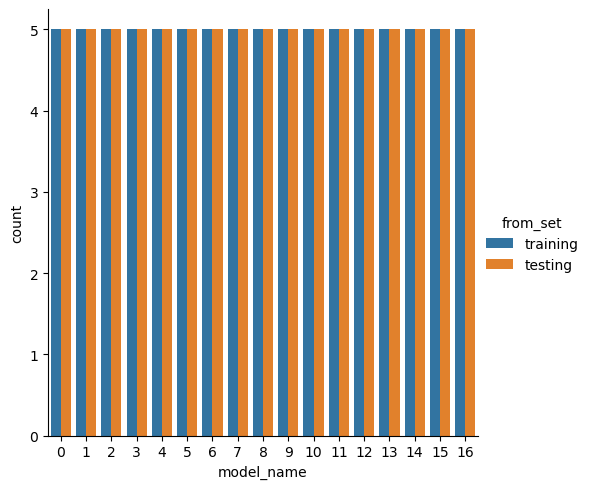

In [22]:
sns.catplot(data = cv_results, x='model_name', hue='from_set', kind='count')

plt.show()

The ACCURACY for each model in each FOLD is shown below via a strip plot

C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


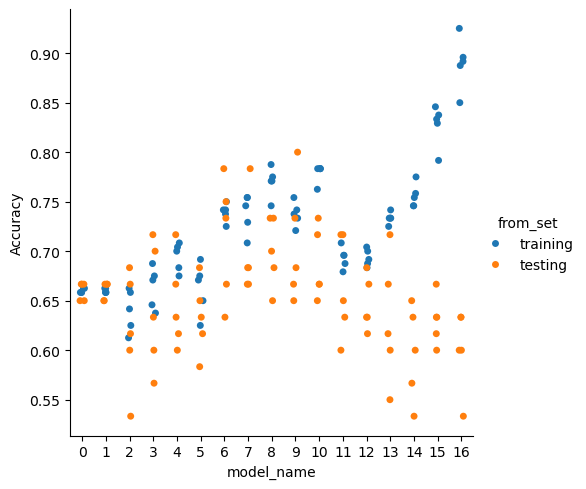

In [24]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set')

plt.show()

Model 16 is **OVERFIT**!

But as already discussed we are focused on the AVERAGE performance.

C:\Users\Canye\AppData\Local\Temp\ipykernel_11924\3252099426.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False,
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


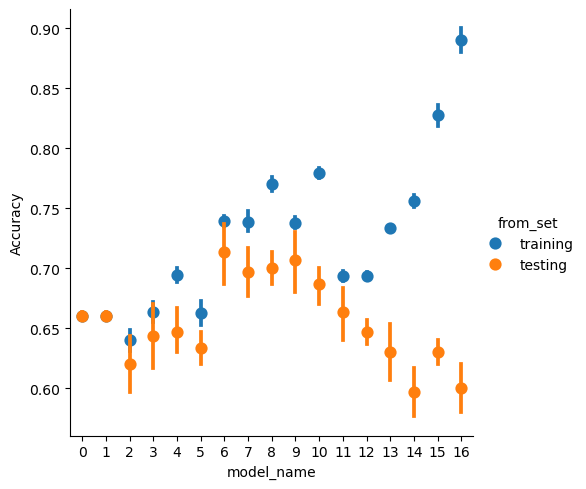

In [25]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False,
            errorbar=('ci', 68))

plt.show()

### Model Selection

Select the BEST model and then FIT on the ENTIRE data set.

In [26]:
formula_list[6]

'y ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)'

In [27]:
ybest, Xbest = dmatrices(formula_list[6], data=df)

In [28]:
sk_best_mod = sk_min_loss.fit( Xbest, ybest.ravel() )

In [29]:
sk_best_mod.coef_

array([[ 0.23364168,  0.51073758, -0.98873177,  0.19716049, -0.02406596,
        -0.68377165, -0.62366625, -0.16963101,  0.14722636]])

Make predictions on a new visualization grid.

In [30]:
input_grid = pd.DataFrame([ (x1, x2, x3, x4, x5) for x1 in np.linspace(df.x1.min(), df.x1.max(), num=101)
                                                 for x2 in np.linspace(df.x2.min(), df.x2.max(), num=9)
                                                 for x3 in [df.x3.mean()]
                                                 for x4 in [df.x4.mean()]
                                                 for x5 in df.x5.unique() ],
                          columns=['x1', 'x2', 'x3', 'x4', 'x5'])

Make the FEATURE array for the GRID.

In [31]:
from patsy import dmatrix

In [32]:
formula_list[6]

'y ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)'

In [33]:
type( formula_list[6] )

str

In [34]:
formula_list[6][1:]

' ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)'

In [35]:
input_grid

,x1,x2,x3,x4,x5
0,-2.913116,-3.008946,0.002302,0.001372,c
1,-2.913116,-3.008946,0.002302,0.001372,b
2,-2.913116,-3.008946,0.002302,0.001372,a
3,-2.913116,-2.242719,0.002302,0.001372,c
4,-2.913116,-2.242719,0.002302,0.001372,b
...,...,...,...,...,...
2722,2.783826,2.354646,0.002302,0.001372,b
2723,2.783826,2.354646,0.002302,0.001372,a
2724,2.783826,3.120873,0.002302,0.001372,c
2725,2.783826,3.120873,0.002302,0.001372,b


Remove the output from the FORMULA to make the visualization grid FEATURE array!

In [36]:
Xgrid = dmatrix( formula_list[6][1:], data = input_grid)

In [37]:
Xgrid.shape

(2727, 9)

In [38]:
Xbest.shape

(300, 9)

Predict the visualization grid with the best model!

Return the PROBABILITIES.

In [39]:
pred_grid_sk_best = sk_best_mod.predict_proba( Xgrid )

In [40]:
pred_grid_sk_best[:5, :]

array([[9.99940407e-01, 5.95931783e-05],
       [9.99940407e-01, 5.95931783e-05],
       [9.99940407e-01, 5.95931783e-05],
       [9.99656469e-01, 3.43531210e-04],
       [9.99656469e-01, 3.43531210e-04]])

In [42]:
sk_best_mod.classes_

array([0., 1.])

In [43]:
dfviz = input_grid.copy()

In [44]:
dfviz['pred_probability'] = pd.Series( pred_grid_sk_best[:, sk_best_mod.classes_ == 1].ravel(), index=dfviz.index )

In [45]:
dfviz

,x1,x2,x3,x4,x5,pred_probability
0,-2.913116,-3.008946,0.002302,0.001372,c,0.000060
1,-2.913116,-3.008946,0.002302,0.001372,b,0.000060
2,-2.913116,-3.008946,0.002302,0.001372,a,0.000060
3,-2.913116,-2.242719,0.002302,0.001372,c,0.000344
4,-2.913116,-2.242719,0.002302,0.001372,b,0.000344
...,...,...,...,...,...,...
2722,2.783826,2.354646,0.002302,0.001372,b,0.000080
2723,2.783826,2.354646,0.002302,0.001372,a,0.000080
2724,2.783826,3.120873,0.002302,0.001372,c,0.000003
2725,2.783826,3.120873,0.002302,0.001372,b,0.000003


C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


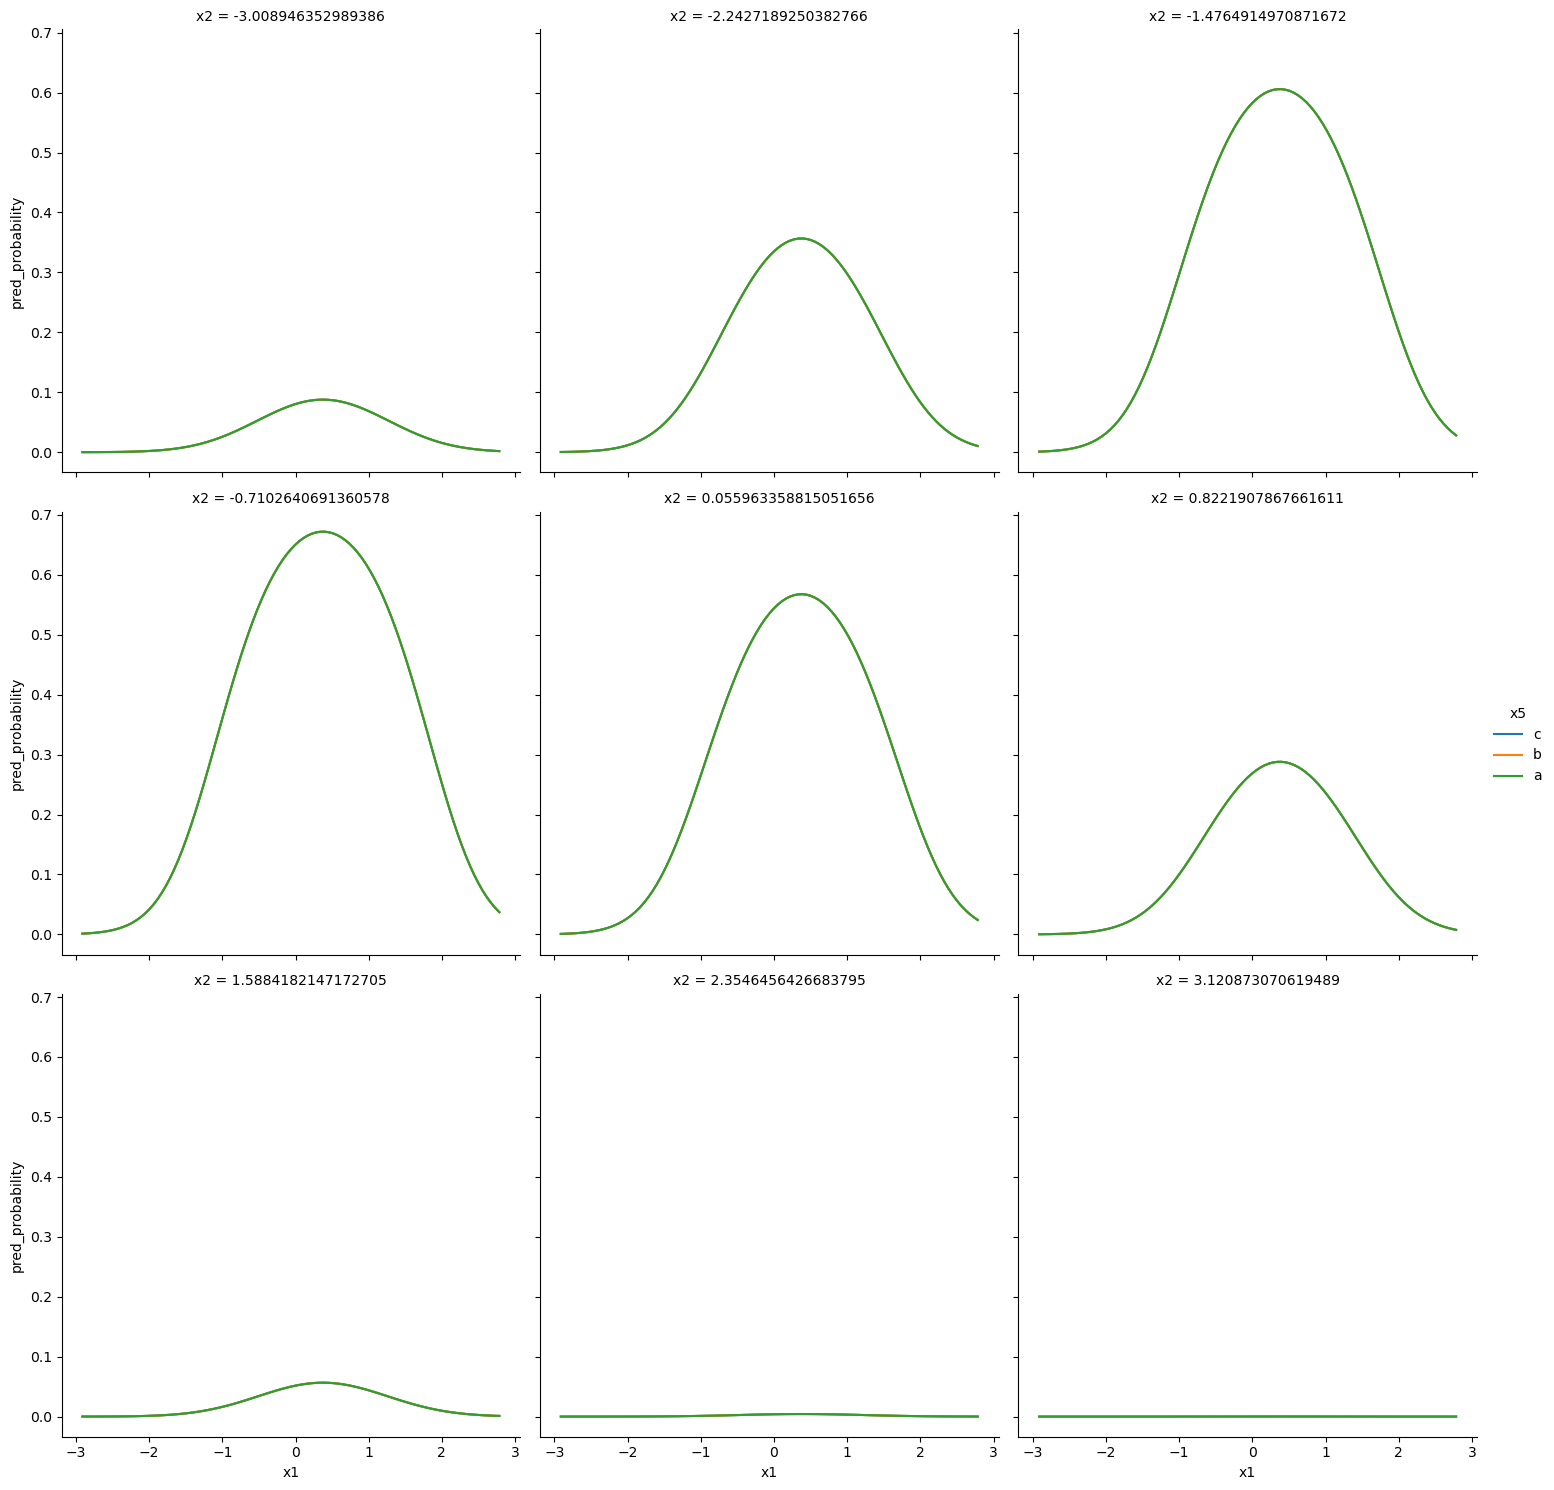

In [46]:
sns.relplot(data = dfviz, x='x1', y='pred_probability', hue='x5', col='x2',
            kind='line', estimator=None, units='x5', col_wrap=3)

plt.show()